# Explore here

In [18]:
# Your code here
# !unzip /workspaces/time-series-project-tutorial/acea-water-prediction.zip #unzip file

Archive:  /workspaces/time-series-project-tutorial/acea-water-prediction.zip
replace Aquifer_Auser.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization
from colorama import Fore

from sklearn.metrics import mean_absolute_error, mean_squared_error #to check how model is doing
import math

np.random.seed(10) # if we run our code multiple times we get the same combinations, good practice

In [20]:
p_data = pd.read_csv("/workspaces/time-series-project-tutorial/src/Aquifer_Petrignano.csv")
p_data.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [21]:
# Remove old rows
p_data = p_data[p_data.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True) # checking if here are any not NaN, drop = True: prevents the index duplicate from appearing
# removes rows where the rainfall_bastia_umbra has NaNs
# Remove not usefull columns
p_data = p_data.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)  # removing the two columns from the dataframe. axis = 0 removes rows, axis = 1 removes columns
# removing columns because they are not useful

In [22]:
#easier column names
p_data.columns = ['date', 'rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 'river_hydrometry']

targets = ['depth_to_groundwater'] #storing it
features = [feature for feature in p_data.columns if feature not in targets] # contains list of features
p_data.head()

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3


In [23]:
#Parse date column
from datetime import datetime, date 

p_data['date'] = pd.to_datetime(p_data['date'], format = '%d/%m/%Y') # converting date to strings to datetype objects
p_data.head().style.set_properties(subset=['date'], **{'background-color': 'dodgerblue'}) # apply styling to date column

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,2009-01-01 00:00:00,0.000000,-31.140000,5.200000,-24530.688000,2.400000
1,2009-01-02 00:00:00,0.000000,-31.110000,2.300000,-28785.888000,2.500000
2,2009-01-03 00:00:00,0.000000,-31.070000,4.400000,-25766.208000,2.400000
3,2009-01-04 00:00:00,0.000000,-31.050000,0.800000,-27919.296000,2.400000
4,2009-01-05 00:00:00,0.000000,-31.010000,-1.900000,-29854.656000,2.300000


/tmp/ipykernel_483/3588863147.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sns.lineplot(x=p_data['date'], y=p_data[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue') # x axis is date, y axis is features
/tmp/ipykernel_483/3588863147.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sns.lineplot(x=p_data['date'], y=p_data[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue') # x axis is date, y axis is features
/tmp/ipykernel_483/3588863147.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sns.lineplot(x=p_data['date'], y=p_data[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue') # x axis is date, y axis is features
/tmp/ipykernel_483/3588863147.py:4: FutureWarning: Series.fillna with 

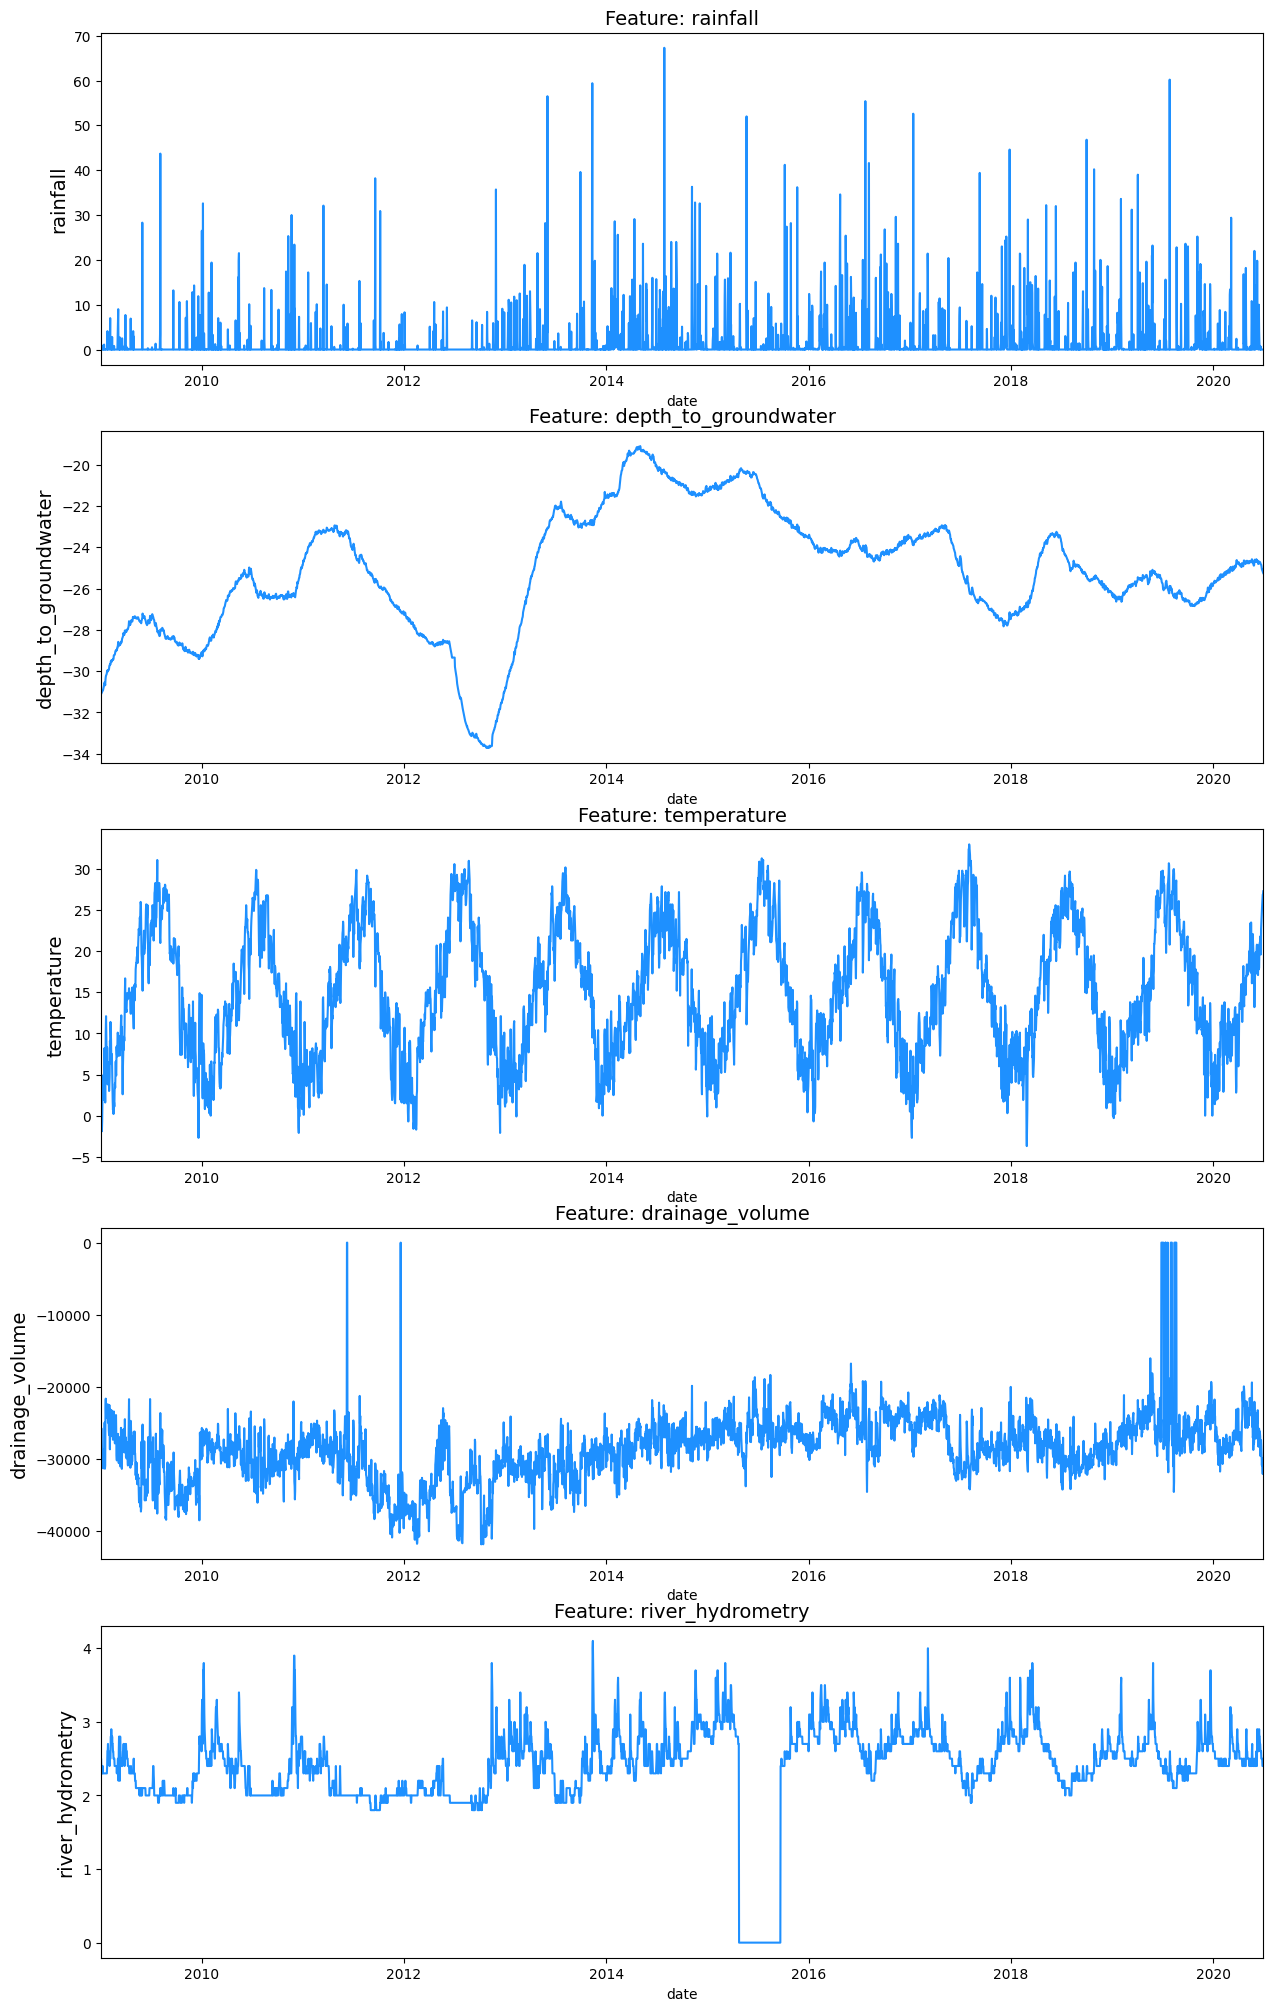

In [24]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

for i, column in enumerate(p_data.drop('date', axis=1).columns): # iterates through every column in database apart from date
    sns.lineplot(x=p_data['date'], y=p_data[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue') # x axis is date, y axis is features
    ax[i].set_title('Feature: {}'.format(column), fontsize=14) # returns index i and the value of the column.
    ax[i].set_ylabel(ylabel=column, fontsize=14) #specifies subplot where plot should be displayed
                      
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])  

In [25]:
#format data
p_data = p_data.sort_values(by='date') #sorts dataframe based on the values in the date column: earliest to latest

# Check time intervals
p_data['delta'] = p_data['date'] - p_data['date'].shift(1)

p_data[['date', 'delta']].head()

,date,delta
0,2009-01-01,NaT
1,2009-01-02,1 days
2,2009-01-03,1 days
3,2009-01-04,1 days
4,2009-01-05,1 days


In [26]:
p_data['delta'].sum(), p_data['delta'].count() #calcualtes sum of all values in the delta column - all the time is going to be summed up in the delta column, count is giving the number on non NaN values

(Timedelta('4198 days 00:00:00'), 4198)

In [27]:
# creating new rows and times to see if they are useful

In [28]:
#handle null values # drop delta because useless
p_data = p_data.drop('delta', axis=1)
p_data.isna().sum()

date                     0
rainfall                 0
depth_to_groundwater    27
temperature              0
drainage_volume          1
river_hydrometry         0
dtype: int64

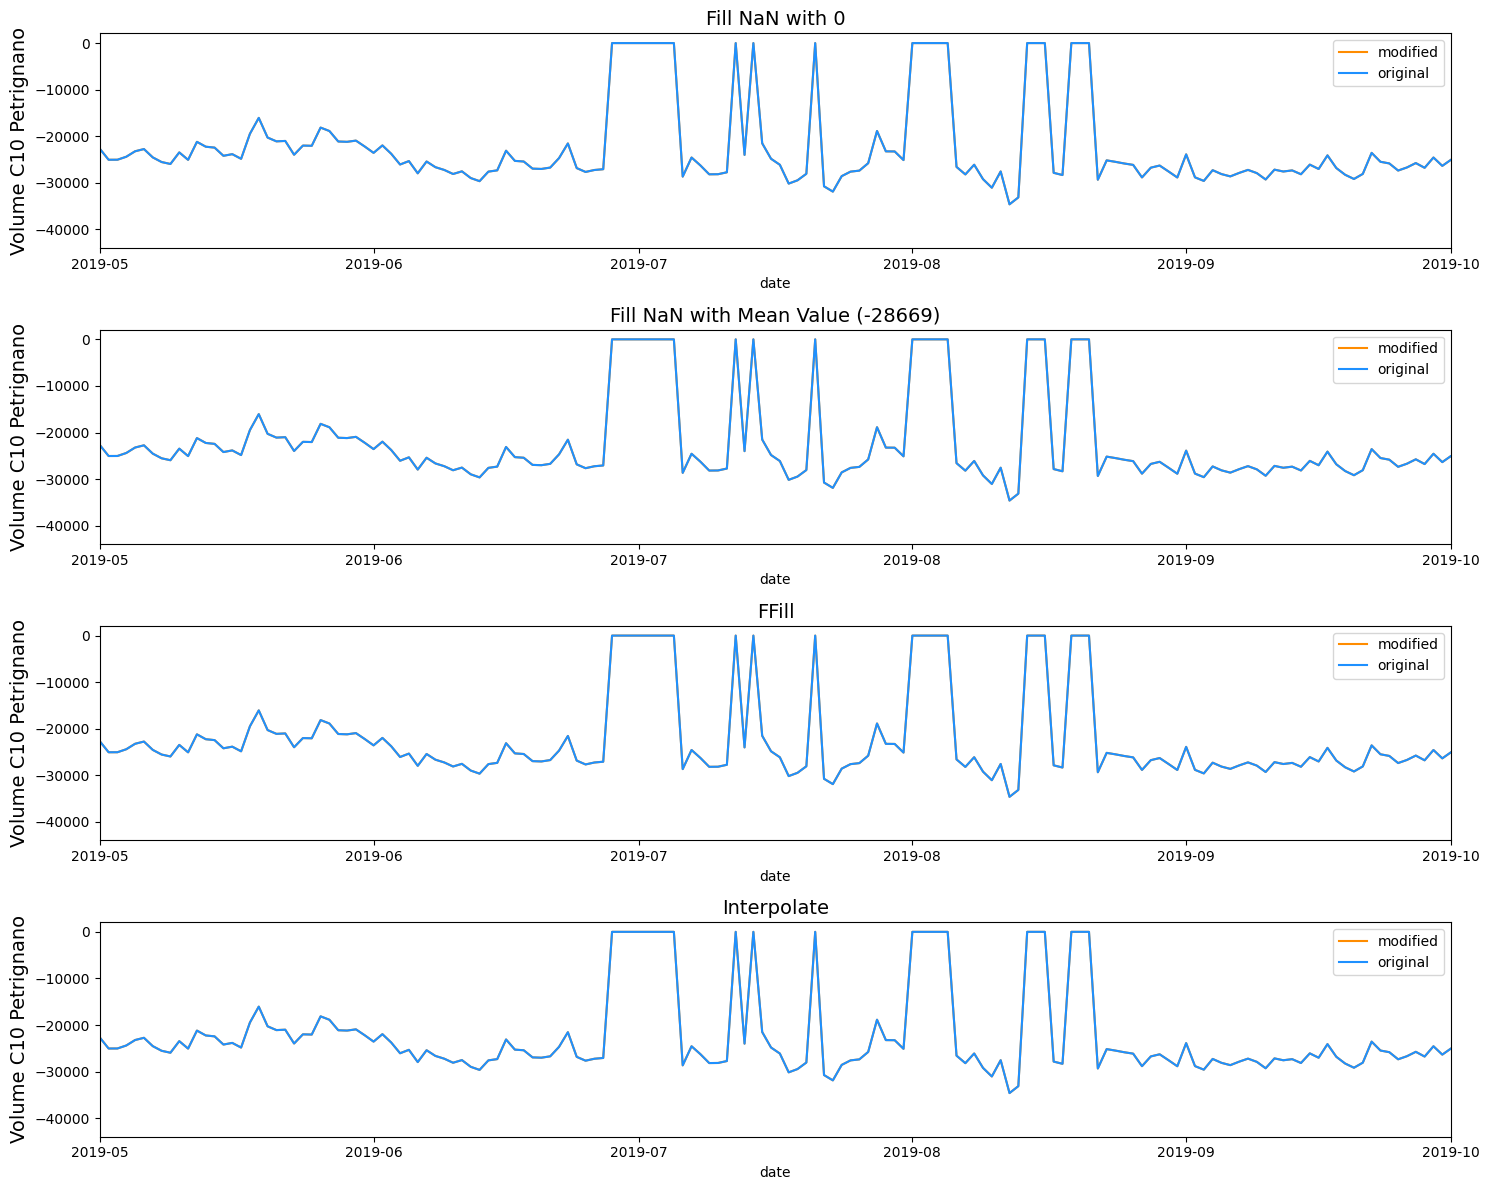

In [29]:
#fill nan with interpolated values. interpolated is when known values are used to estimate an unknown value or set of values. 
#Solution taught me this method and I did further research into it
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

sns.lineplot(x=p_data['date'], y=p_data['drainage_volume'].fillna(0), ax=ax[0], color='darkorange', label = 'modified')
sns.lineplot(x=p_data['date'], y=p_data['drainage_volume'].fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'original')
ax[0].set_title('Fill NaN with 0', fontsize=14)
ax[0].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

mean_drainage = p_data['drainage_volume'].mean()
sns.lineplot(x=p_data['date'], y=p_data['drainage_volume'].fillna(mean_drainage), ax=ax[1], color='darkorange', label = 'modified')
sns.lineplot(x=p_data['date'], y=p_data['drainage_volume'].fillna(np.inf), ax=ax[1], color='dodgerblue', label = 'original')
ax[1].set_title(f'Fill NaN with Mean Value ({mean_drainage:.0f})', fontsize=14)
ax[1].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=p_data['date'], y=p_data['drainage_volume'].ffill(), ax=ax[2], color='darkorange', label = 'modified')
sns.lineplot(x=p_data['date'], y=p_data['drainage_volume'].fillna(np.inf), ax=ax[2], color='dodgerblue', label = 'original')
ax[2].set_title(f'FFill', fontsize=14)
ax[2].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=p_data['date'], y=p_data['drainage_volume'].interpolate(), ax=ax[3], color='darkorange', label = 'modified')
sns.lineplot(x=p_data['date'], y=p_data['drainage_volume'].fillna(np.inf), ax=ax[3], color='dodgerblue', label = 'original')
ax[3].set_title(f'Interpolate', fontsize=14)
ax[3].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

for i in range(4):
    ax[i].set_xlim([date(2019, 5, 1), date(2019, 10, 1)])
    
plt.tight_layout()
plt.show()

In [30]:
# what is the best way of handling the NaN? Interpolate

In [31]:
p_data['drainage_volume'] = p_data['drainage_volume'].interpolate()
p_data['river_hydrometry'] = p_data['river_hydrometry'].interpolate()
p_data['depth_to_groundwater'] = p_data['depth_to_groundwater'].interpolate() # if we have 1 and 3 it will take a value 2

In [32]:
# down sampling 
downsample = p_data[['date',
                 'depth_to_groundwater', 
                 'temperature',
                 'drainage_volume', 
                 'river_hydrometry',
                 'rainfall'
                ]].resample('7D', on='date').mean().reset_index(drop=False) #getting original columns from dataframe. data is grouped in weekly intervals. for each interval the mean is calculated.

p_data = downsample.copy() #creating a downsample version. 

In [33]:
#check if data is stationary
from statsmodels.tsa.stattools import adfuller

result = adfuller(p_data['depth_to_groundwater'].values)
result

(-2.8802016493166605,
 0.047699190920208856,
 7,
 592,
 {'1%': -3.441444394224128,
  '5%': -2.8664345376276454,
  '10%': -2.569376663737217},
 -734.3154255877616)

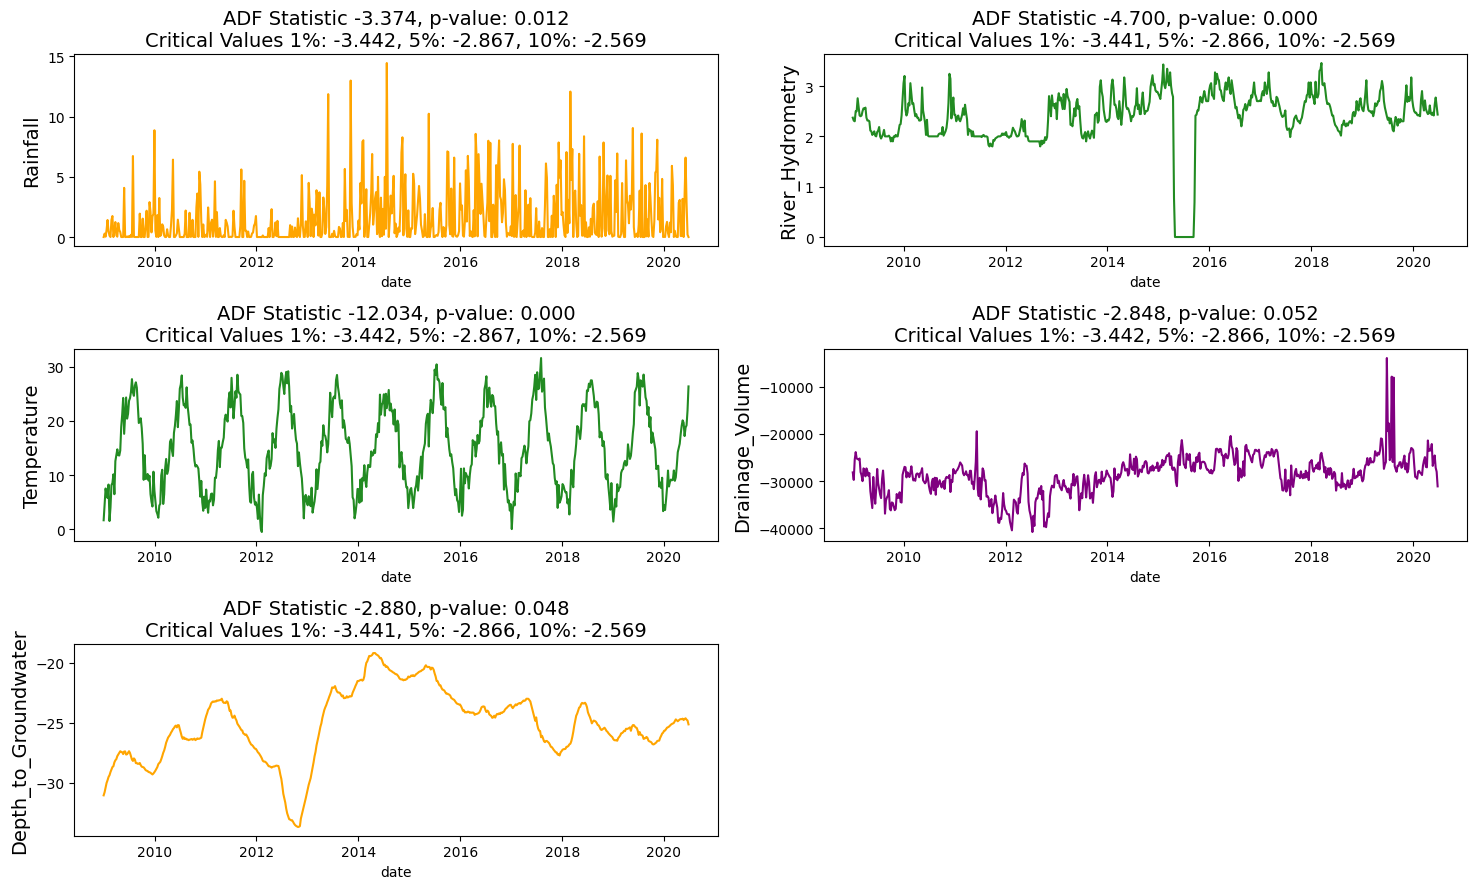

In [34]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))


def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)): # return statistical values to determine if it is stationary or not
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=p_data['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(p_data['rainfall'].values, 'Rainfall', ax[0, 0])
visualize_adfuller_results(p_data['temperature'].values, 'Temperature', ax[1, 0])
visualize_adfuller_results(p_data['river_hydrometry'].values, 'River_Hydrometry', ax[0, 1])
visualize_adfuller_results(p_data['drainage_volume'].values, 'Drainage_Volume', ax[1, 1])
visualize_adfuller_results(p_data['depth_to_groundwater'].values, 'Depth_to_Groundwater', ax[2, 0])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()  # pay attention at the p-value. if < 0.05 it is likely stationary

/tmp/ipykernel_483/4200344782.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(p_data['depth_to_groundwater_log'], ax=ax[1])


<Axes: xlabel='depth_to_groundwater_log', ylabel='Density'>

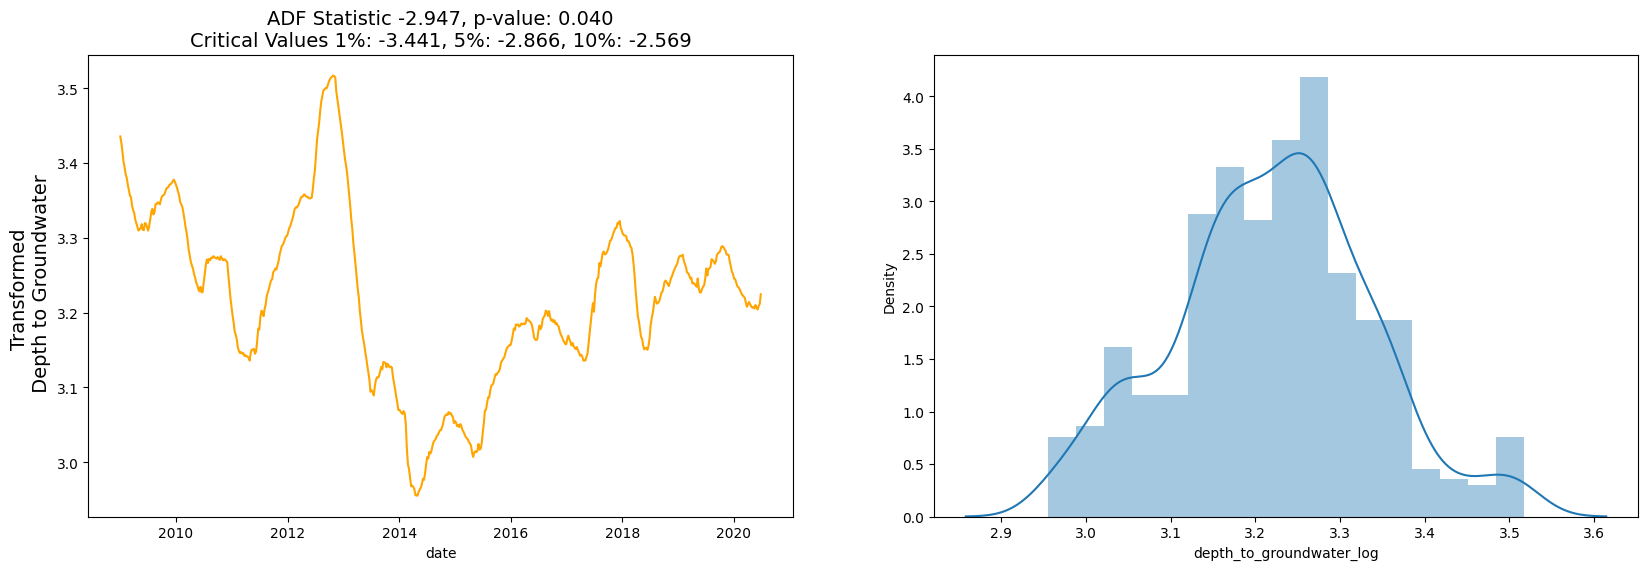

In [35]:
# Log Transform of absolute values
# (Log transoform of negative values will return NaN)
p_data['depth_to_groundwater_log'] = np.log(abs(p_data['depth_to_groundwater']))

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
visualize_adfuller_results(p_data['depth_to_groundwater_log'], 'Transformed \n Depth to Groundwater', ax[0])

sns.distplot(p_data['depth_to_groundwater_log'], ax=ax[1])

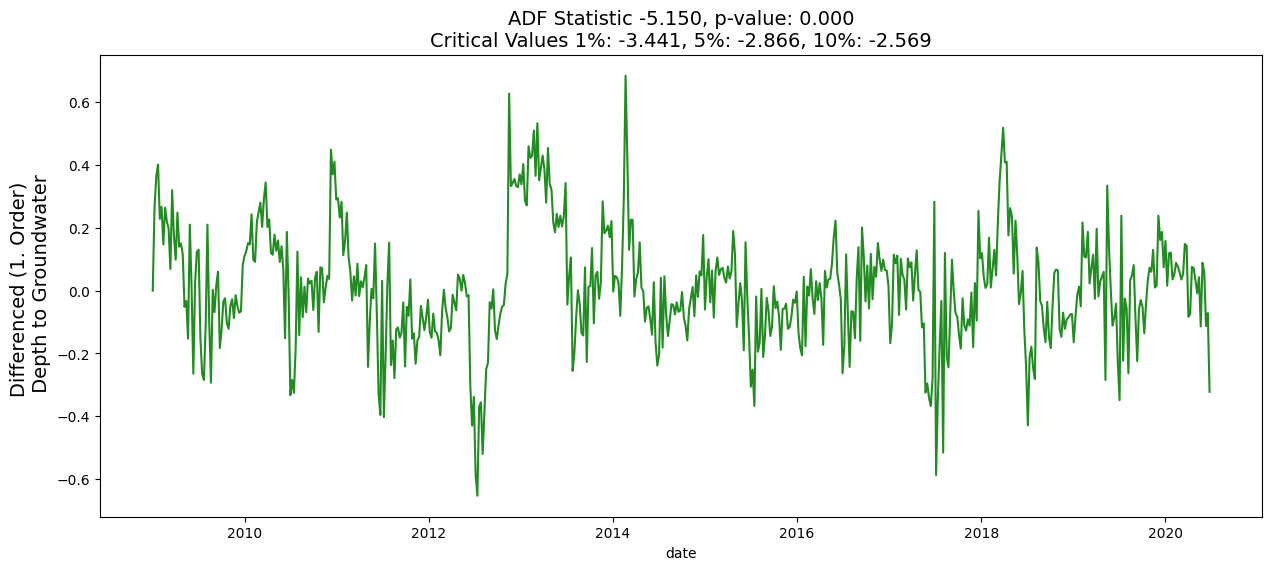

In [36]:
# First Order Differencing
ts_diff = np.diff(p_data['depth_to_groundwater'])
p_data['depth_to_groundwater_diff_1'] = np.append([0], ts_diff)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(p_data['depth_to_groundwater_diff_1'], 'Differenced (1. Order) \n Depth to Groundwater', ax)

In [37]:
#Feature engineering 
p_data['year'] = pd.DatetimeIndex(p_data['date']).year
p_data['month'] = pd.DatetimeIndex(p_data['date']).month
p_data['day'] = pd.DatetimeIndex(p_data['date']).day
p_data['day_of_year'] = pd.DatetimeIndex(p_data['date']).dayofyear
p_data['quarter'] = pd.DatetimeIndex(p_data['date']).quarter
p_data['season'] = p_data['month'] % 12 // 3 + 1

p_data[['date', 'year', 'month', 'day', 'day_of_year', 'quarter', 'season']].head()

,date,year,month,day,day_of_year,quarter,season
0,2009-01-01,2009,1,1,1,1,1
1,2009-01-08,2009,1,8,8,1,1
2,2009-01-15,2009,1,15,15,1,1
3,2009-01-22,2009,1,22,22,1,1
4,2009-01-29,2009,1,29,29,1,1


In [38]:
#time series decompostion 
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns =  [
    'rainfall', 'temperature', 'drainage_volume', 
    'river_hydrometry', 'depth_to_groundwater'
]

for column in core_columns:
    decomp = seasonal_decompose(p_data[column], period=52, model='additive', extrapolate_trend='freq')
    p_data[f"{column}_trend"] = decomp.trend
    p_data[f"{column}_seasonal"] = decomp.seasonal

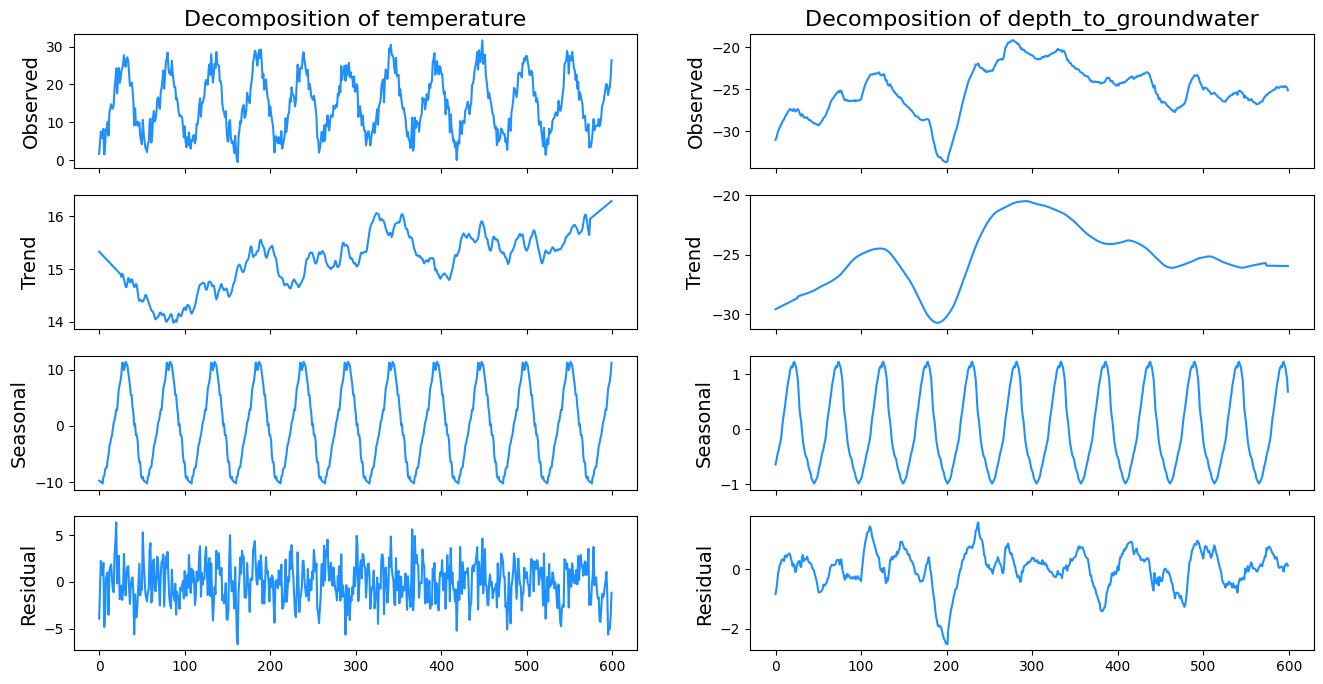

In [39]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8))

for i, column in enumerate(['temperature', 'depth_to_groundwater']):
    
    res = seasonal_decompose(p_data[column], period=52, model='additive', extrapolate_trend='freq')

    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue')
    ax[3,i].set_ylabel('Residual', fontsize=14)

plt.show()

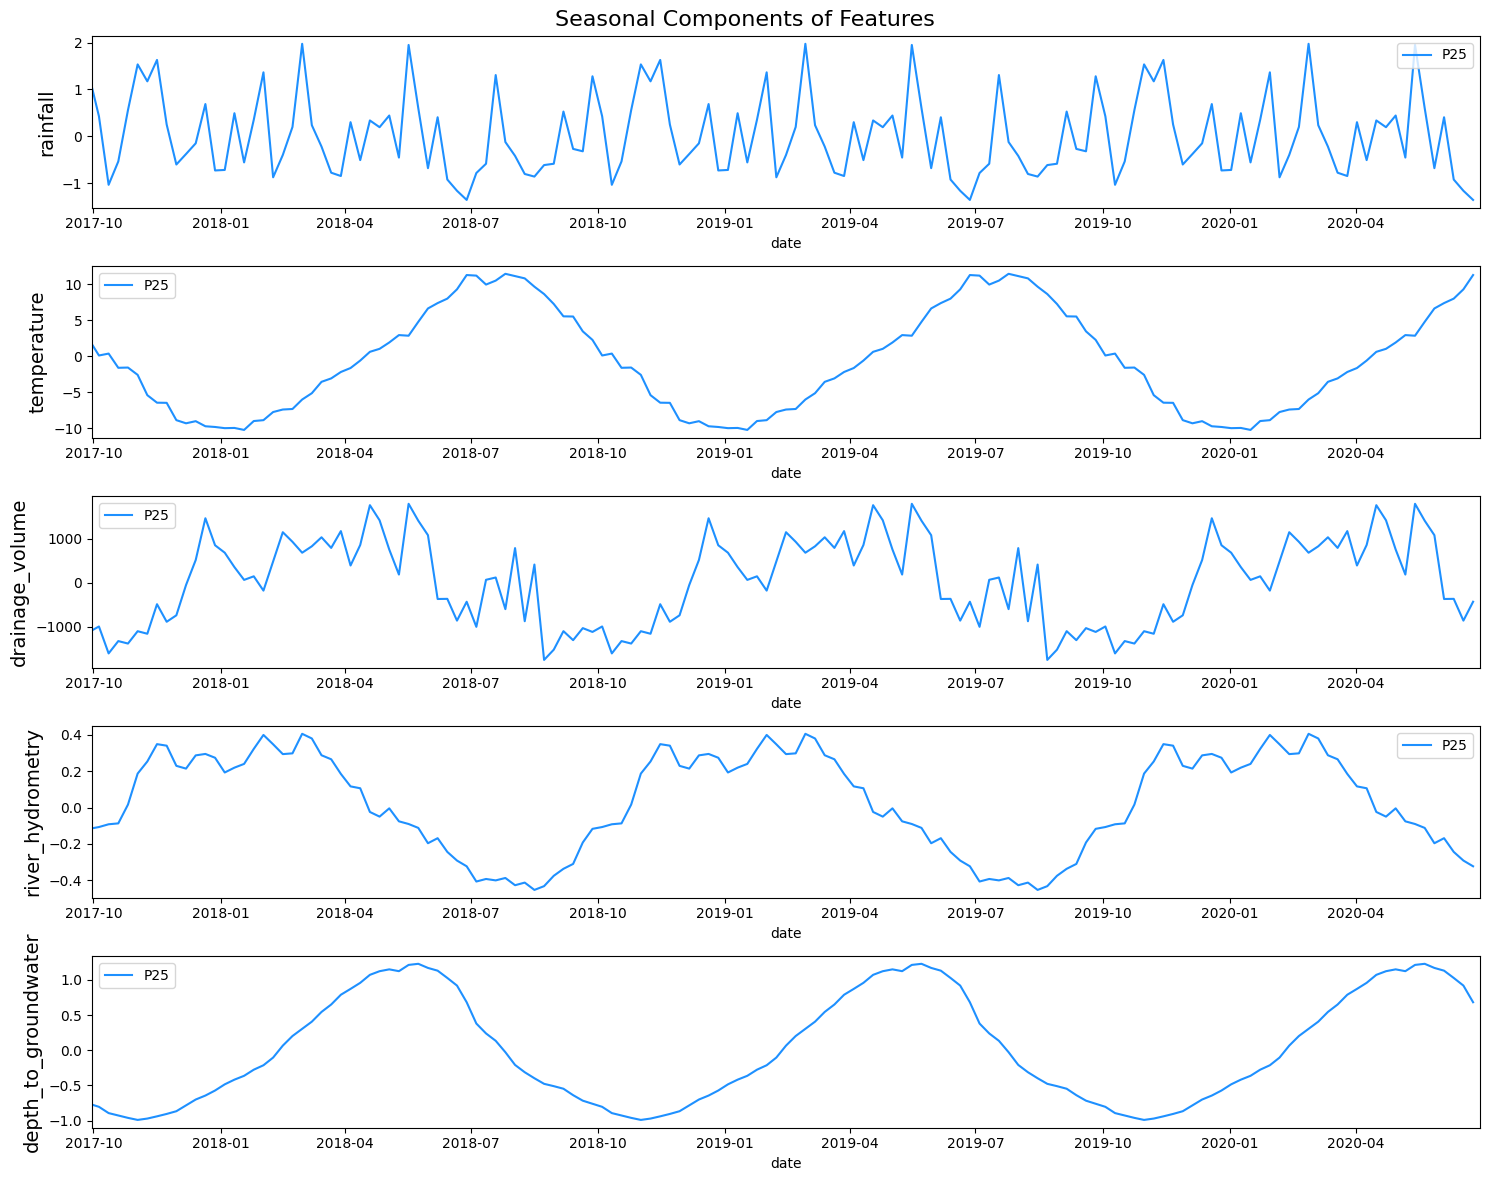

In [40]:
weeks_in_month = 4

for column in core_columns:
    p_data[f'{column}_seasonal_shift_b_2m'] = p_data[f'{column}_seasonal'].shift(-2 * weeks_in_month)
    p_data[f'{column}_seasonal_shift_b_1m'] = p_data[f'{column}_seasonal'].shift(-1 * weeks_in_month)
    p_data[f'{column}_seasonal_shift_1m'] = p_data[f'{column}_seasonal'].shift(1 * weeks_in_month)
    p_data[f'{column}_seasonal_shift_2m'] = p_data[f'{column}_seasonal'].shift(2 * weeks_in_month)
    p_data[f'{column}_seasonal_shift_3m'] = p_data[f'{column}_seasonal'].shift(3 * weeks_in_month)
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 12))
f.suptitle('Seasonal Components of Features', fontsize=16)

for i, column in enumerate(core_columns):
    sns.lineplot(x=p_data['date'], y=p_data[column + '_seasonal'], ax=ax[i], color='dodgerblue', label='P25')
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlim([date(2017, 9, 30), date(2020, 6, 30)])
    
plt.tight_layout()
plt.show()

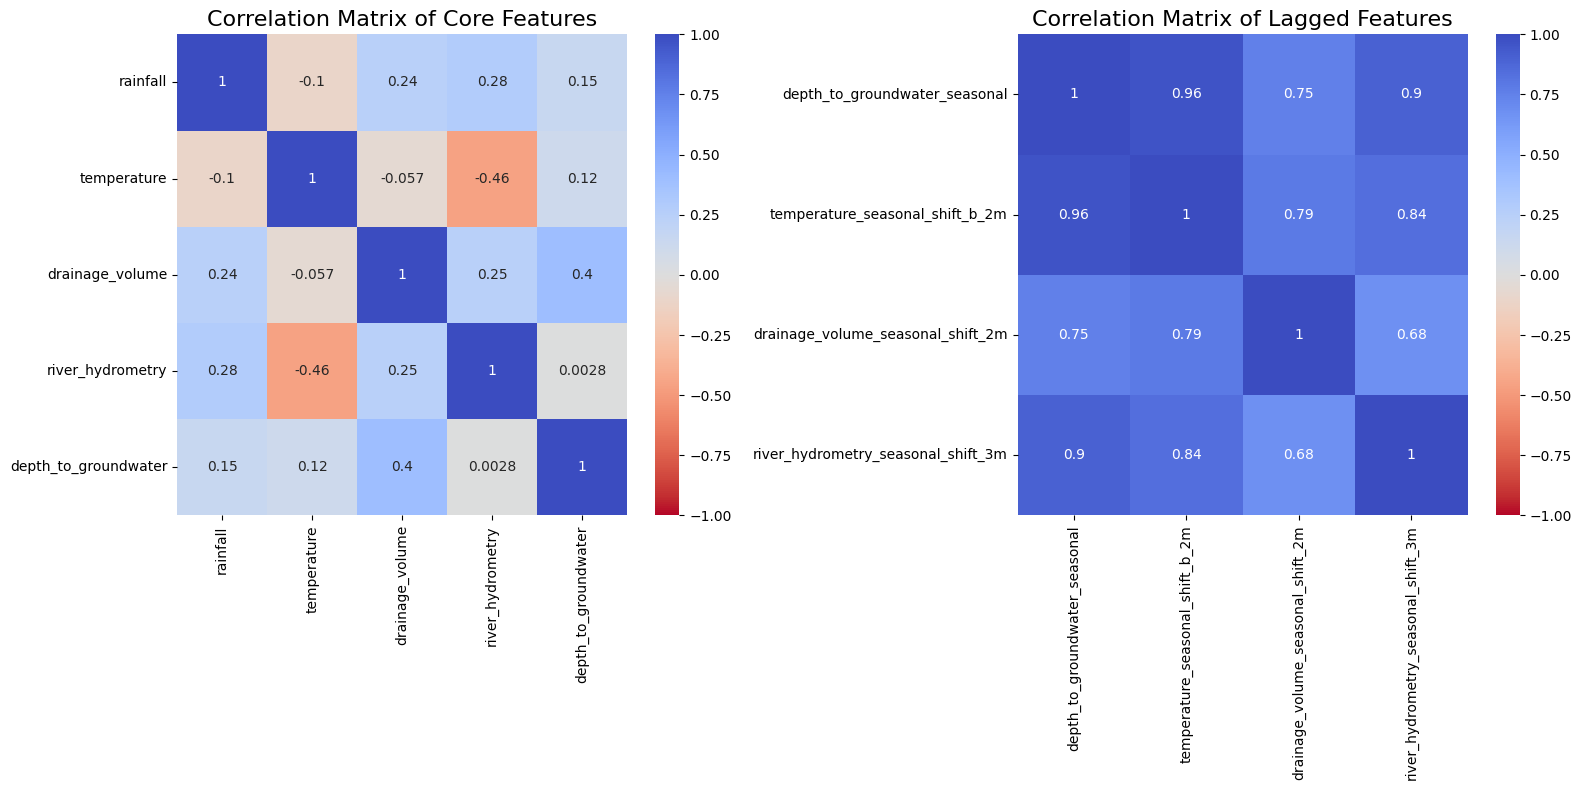

In [41]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

corrmat = p_data[core_columns].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
ax[0].set_title('Correlation Matrix of Core Features', fontsize=16)

shifted_cols = [
    'depth_to_groundwater_seasonal',         
    'temperature_seasonal_shift_b_2m',
    'drainage_volume_seasonal_shift_2m', 
    'river_hydrometry_seasonal_shift_3m'
]
corrmat = p_data[shifted_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
ax[1].set_title('Correlation Matrix of Lagged Features', fontsize=16)


plt.tight_layout()
plt.show()

In [42]:
train_size = int(0.85 * len(p_data))
test_size = len(p_data) - train_size

univariate_df = p_data[['date', 'depth_to_groundwater']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

from statsmodels.tsa.arima.model import ARIMA

# Fit model
model = ARIMA(y_train, order=(1,1,1))
model_fit = model.fit()

# Prediction with ARIMA
y_pred = model_fit.forecast(90)



# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

510 90
RMSE: 1.402615843711107


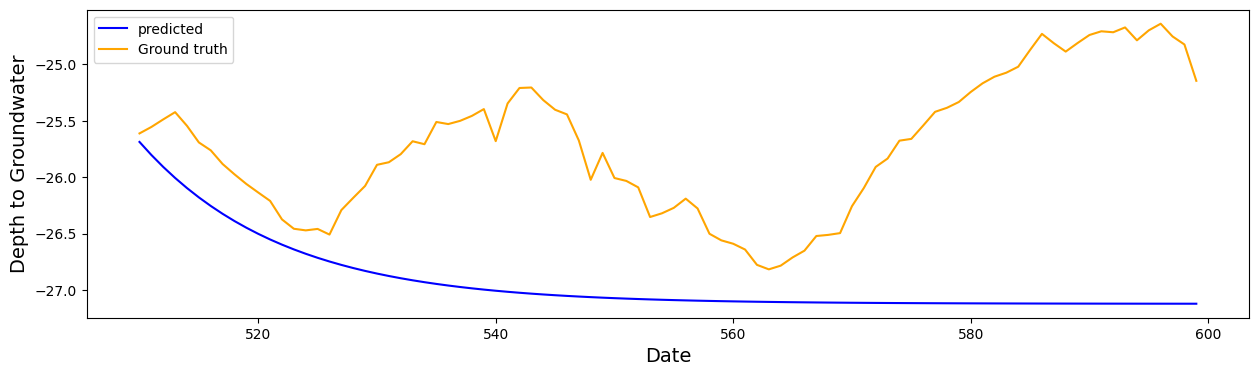

In [43]:
f, ax = plt.subplots(1)
f.set_figheight(4)
f.set_figwidth(15)

sns.lineplot(x=x_valid.index, y=y_pred, ax=ax, color='blue', label='predicted') #navajowhite
sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

In [44]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-631.136, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-242.692, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-574.047, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-427.347, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-243.054, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-629.209, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-629.237, Time=0.48 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-492.779, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-611.065, Time=0.28 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-628.351, Time=0.65 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-632.995, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-428.258, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-575.735, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-631.069, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0]          

In [45]:
from sklearn.preprocessing import MinMaxScaler

data = univariate_df.filter(['y'])
#Convert the dataframe to a numpy array
dataset = data.values

scaler = MinMaxScaler(feature_range=(-1, 0))
scaled_data = scaler.fit_transform(dataset)

scaled_data[:10]

array([[-0.81796644],
       [-0.79970385],
       [-0.7745311 ],
       [-0.74679171],
       [-0.73099704],
       [-0.71253702],
       [-0.7023692 ],
       [-0.68410661],
       [-0.66890424],
       [-0.65528134]])

In [47]:
#multivariate time series 
feature_columns = [
    'rainfall',
    'temperature',
    'drainage_volume',
    'river_hydrometry',
]
target_column = ['depth_to_groundwater']

train_size = int(0.85 * len(p_data))

multivariate_df = p_data[['date'] + target_column + feature_columns].copy()
multivariate_df.columns = ['ds', 'y'] + feature_columns

train = multivariate_df.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

train.head()

,ds,y,rainfall,temperature,drainage_volume,river_hydrometry
0,2009-01-01,-31.048571,0.000000,1.657143,-28164.918857,2.371429
1,2009-01-08,-30.784286,0.285714,4.571429,-29755.789714,2.314286
2,2009-01-15,-30.420000,0.028571,7.528571,-25463.190857,2.300000
3,2009-01-22,-30.018571,0.585714,6.214286,-23854.422857,2.500000
4,2009-01-29,-29.790000,1.414286,5.771429,-25210.532571,2.500000


In [48]:
from prophet import Prophet


# Train the model
model = Prophet()
model.add_regressor('rainfall')
model.add_regressor('temperature')
model.add_regressor('drainage_volume')
model.add_regressor('river_hydrometry')

# Fit the model with train set
model.fit(train)

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred['yhat']))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

Importing plotly failed. Interactive plots will not work.
07:48:46 - cmdstanpy - INFO - Chain [1] start processing
07:48:46 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.996701356662564


/home/vscode/.local/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/vscode/.local/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


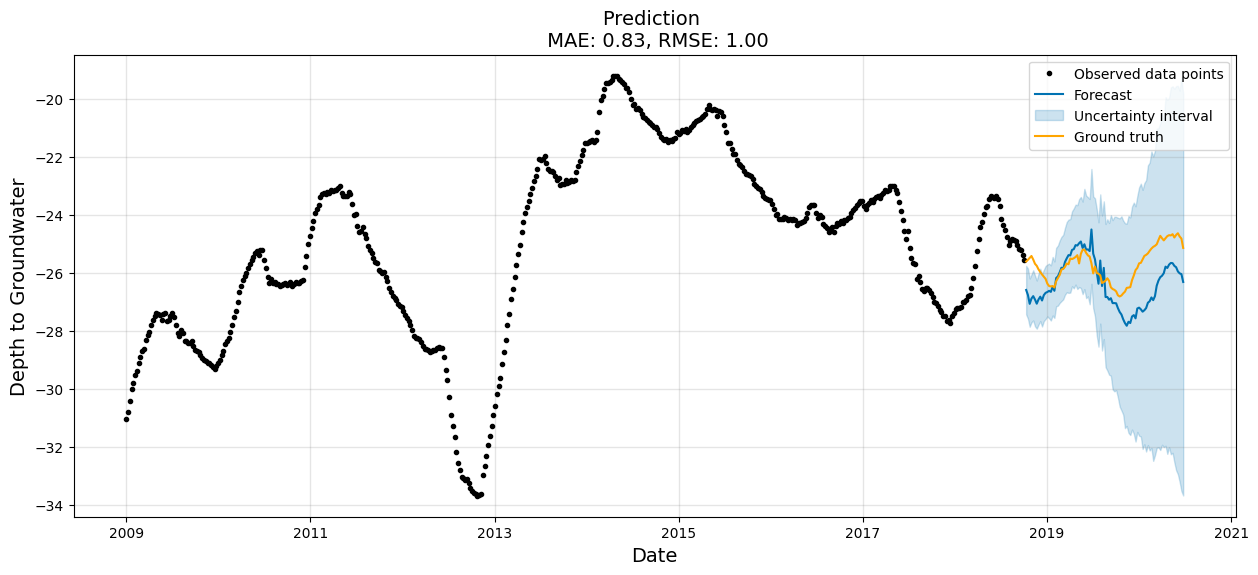

In [49]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()